In [44]:
import tensorflow as tf
import keras.backend as K
from keras.models import model_from_yaml
import numpy as np
import os
import glob
from pybedtools import BedTool
import genomelake
from genomelake.extractors import ArrayExtractor 
from plot import seqlogo_fig

In [2]:
import tensorflow as tf
import keras.backend as K
from keras.models import model_from_yaml
import numpy as np
import os
import glob
from pybedtools import BedTool
import genomelake
from genomelake.extractors import ArrayExtractor 
from plot import seqlogo_fig

In [3]:
path_to_model = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/seq_meth_AC_models/logdir_0wDEL2/model.arch.yaml'
path_to_model_weights = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/seq_meth_AC_models/logdir_0wDEL2/model.weights.h5'

In [4]:
with open(path_to_model,'r') as f:
    model = model_from_yaml(f)
    model.load_weights(path_to_model_weights)

In [5]:
path_to_intervals = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/label_regions/labeled_intervals/DEL2_DapSeq_bin200_flank400_stride200.TAIR10.intervals.bed'
path_to_labels = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/label_regions/labeled_intervals/DEL2_DapSeq_bin200_flank400_stride200.TAIR10.labels.npy'


In [75]:
intervals_dataframe = BedTool(path_to_intervals).to_dataframe()

In [76]:
labels = np.load(path_to_labels)

In [77]:
pos_indexes = np.where(labels ==1)[0]

In [78]:
pos_indexes

array([    35,    254,    255, ..., 594512, 594726, 594919])

In [79]:
pos_intervals = intervals_dataframe.values[pos_indexes]

In [80]:
if not os.path.exists('./tmp'):
    os.makedirs('./tmp/')
path_to_pos_intervals_file = './tmp/pos_intervals.bed'
with open(path_to_pos_intervals_file,'w') as f:
    for line in pos_intervals:
        f.write(line[0]+'\t'+str(line[1])+'\t'+str(line[2])+'\n')
    f.close()    

In [81]:
path_to_arabidopsis_genome = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/memmaped_bcolz_datasets/TAIR10.fa/'
genome_extractor = ArrayExtractor(path_to_arabidopsis_genome)

In [82]:
path_to_C_methylation = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/memmaped_bcolz_datasets/methylation_dir/Arabidopsis_WGBS-Col-0-GSM1942127.Bismark_v0.19.0/GSM1942127.Bismark_v0.19.0.se.normalized.renamed.bigWig/'
path_to_A_methylation = '/srv/scratch/manyu/NIPS_workshop_tests/train_models/DapSeq/memmaped_bcolz_datasets/methylation_dir/Arabidopsis_6mA_methylation/GSM2157793_Col_6mA_modification.normalized.renamed.bigWig/'
C_meth_extractor  = ArrayExtractor(path_to_C_methylation)
A_meth_extractor = ArrayExtractor(path_to_A_methylation)

In [83]:
pos_intervals_extracted_arr = genome_extractor(BedTool(path_to_pos_intervals_file))
A_methylation = A_meth_extractor(BedTool(path_to_pos_intervals_file))
C_methylation = C_meth_extractor(BedTool(path_to_pos_intervals_file))

In [84]:
print(pos_intervals.shape)
pos_intervals_extracted_arr = np.transpose(pos_intervals_extracted_arr,[0,2,1])
print(pos_intervals.shape)

(1281, 4)
(1281, 4)


In [130]:
pos_intervals_extracted_arr.shape

(1281, 4, 1000)

In [87]:
seq_input = model.get_layer('data/genome_data_dir').input
meth_input_C = model.get_layer('data/methylation_data_dir').input
meth_input_A = model.get_layer('data/A_methylation_data_dir').input
logit = K.sum(model.layers[-2].output,axis = 0)

In [88]:
logit_grad = K.gradients(logit,[seq_input,meth_input_C,meth_input_A])
logit_gradients_func = K.function([seq_input, meth_input_C, meth_input_A,K.learning_phase()], logit_grad)

In [89]:
#ogit_grad_tf = tf.gradients(logit,[seq_input,meth_input_C,meth_input_A])

In [91]:
grad_seq,grad_meth_C,grad_meth_A = logit_gradients_func([pos_intervals_extracted_arr,C_methylation,A_methylation,False])

In [93]:
input_grad_seq = grad_seq*pos_intervals_extracted_arr
input_grad_meth_C  = grad_meth_C*C_methylation
input_grad_meth_A = grad_meth_A*A_methylation

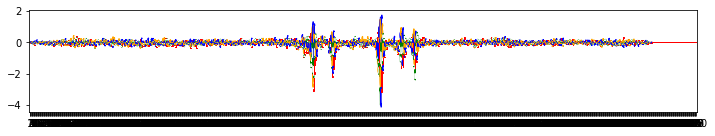

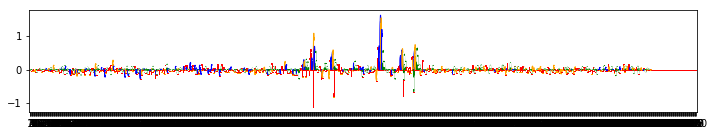

In [114]:
index = 405
lower = 0
upper = 1000
fig = seqlogo_fig(grad_seq[index].transpose()[lower:upper])
fig_input_grad_seq = seqlogo_fig(input_grad_seq[index].transpose()[lower:upper])

In [120]:
c_locations = pos_intervals_extracted_arr[:,1,:]
g_locations = pos_intervals_extracted_arr[:,2,:]
a_locations = pos_intervals_extracted_arr[:,0,:]
t_locations = pos_intervals_extracted_arr[:,3,:]

# c_meth = np.expand_dims(c_locations*extracted_intervals_Cmeth,axis=-1)
# g_meth = np.expand_dims(g_locations*extracted_intervals_Cmeth,axis=-1)
# a_meth = np.expand_dims(a_locations*extracted_intervals_Ameth,axis=-1)
# t_meth = np.expand_dims(t_locations*extracted_intervals_Ameth,axis=-1)
# seq_meth_input = np.concatenate([a_meth,c_meth,extracted_intervals_seq,g_meth,t_meth],axis=-1)

In [131]:
c_scores = np.expand_dims(c_locations*input_grad_meth_C,axis=-1)
g_scores = np.expand_dims(g_locations*input_grad_meth_C,axis=-1)
a_scores = np.expand_dims(a_locations*input_grad_meth_A,axis=-1)
t_scores = np.expand_dims(t_locations*input_grad_meth_A,axis=-1)
seq_scores_input_grad = np.transpose(input_grad_seq,[0,2,1])
concat_scores = np.concatenate([a_scores,c_scores,seq_scores_input_grad,g_scores,t_scores],axis=-1)

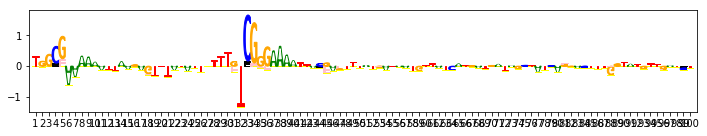

In [157]:
index = 154
lower = 500
upper = 600
fig = seqlogo_fig(concat_scores[index][lower:upper],vocab='Meth_8_channel')


In [129]:
input_grad_seq.shape,input_grad_meth_C.shape

((1281, 4, 1000), (1281, 1000))

In [146]:
meth_c_sums = np.array([np.sum(i) for i in C_methylation])

In [152]:
sorted_for_meth = np.argsort(meth_c_sums*-1)

In [158]:
###Function that calculates the 8 channel input*grad importance score
###Function that calculates the 8 channel gradient score and returns it
###Function that returns the 8 channel sequence in that interval
###After that I need to do the DFIM with methylation, change methylation at some motif locations and
###then look at where on the sequence the things change the most, in terms of the delta importance scores


In [154]:
sorted_for_meth[0:10]

array([ 635, 1056, 1041,  154,  833,  659,  746, 1054,  498,    2])